# resnet

In [1]:
from models.vgg19_model import get_vgg19_model
from models.vit_model import get_vit_model
from models.alexnet_model import get_alexnet_model
from models.gideon_alex_net import get_gideon_alexnet_model
from models.resnet_model import get_resnet_model
from models.resnet_model import get_timm_model
from models.dino_model import get_dinov2_model


c:\Users\e0l07sq\Anaconda3\envs\osteo_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
weights_path = r'saved_models\ResNet50_hard_finetune_best.pth'
img_path = r"data\grand_finalle_data\cropped_by_yolo\test_data\Osteoporosis\Osteoporosis 2_left.JPEG"

In [42]:
def get_resnet50(num_classes):
    model = models.resnet50(pretrained=False)
    
    num_ftrs = model.fc.in_features
    
    classifier = nn.Sequential(
        OrderedDict([
            ("fc1", nn.Linear(num_ftrs, 512)),
            ("relu1", nn.ReLU()),
            ("dropout", nn.Dropout(0.5)),
            ("fc2", nn.Linear(512, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ])
    )
    
    model.fc = classifier
    return model

def get_resnet_model(num_classes):

    model = models.resnet50(pretrained=False)
    dropout = 0.5
    num_ftrs = model.fc.in_features
    classifier = nn.Sequential(
        OrderedDict(
            [
                ("fc1", nn.Linear(num_ftrs, 1024)),
                ("bn1", nn.BatchNorm1d(1024)),
                ("relu1", nn.ReLU()),
                ("dropout1", nn.Dropout(dropout)),
                ("fc2", nn.Linear(1024, 512)),
                ("bn2", nn.BatchNorm1d(512)),
                ("relu2", nn.ReLU()),
                ("dropout2", nn.Dropout(dropout)),
                ("fc3", nn.Linear(512, num_classes)),
            ]
        )
    )
    model.fc = classifier
    return model


def get_timm_model(name=None):
    """
    Returns model, feature_dim.
    name ∈ {"resnet34","resnet50","densenet121","efficientnet_b0"}
    """

    num_classes = 3
    dropout = 0.5
    if name == None:
        name = resnet50

    if name == "resnet34":
        model = models.resnet34(weights="ResNet34_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 512)),
                    ("bn1", nn.BatchNorm1d(512)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(512, 3)),
                ]
            )
        )

    elif name == "resnet50":
        model = models.resnet50(weights="ResNet50_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 1024)),
                    ("bn1", nn.BatchNorm1d(1024)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(1024, 512)),
                    ("bn2", nn.BatchNorm1d(512)),
                    ("relu2", nn.ReLU()),
                    ("dropout2", nn.Dropout(dropout)),
                    ("fc3", nn.Linear(512, 3)),
                ]
            )
        )

    elif name == "densenet121":
        model = models.densenet121(weights="DenseNet121_Weights.DEFAULT")
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(
            OrderedDict(
                [
                    ("fc1", nn.Linear(num_ftrs, 512)),
                    ("bn1", nn.BatchNorm1d(512)),
                    ("relu1", nn.ReLU()),
                    ("dropout1", nn.Dropout(dropout)),
                    ("fc2", nn.Linear(512, 3)),
                ]
            )
        )

    elif name == "efficientnet_b0":
        model = timm.create_model(
            "efficientnet_b0", pretrained=True, num_classes=3
        )

    else:
        raise ValueError("Unknown backbone")

    return model



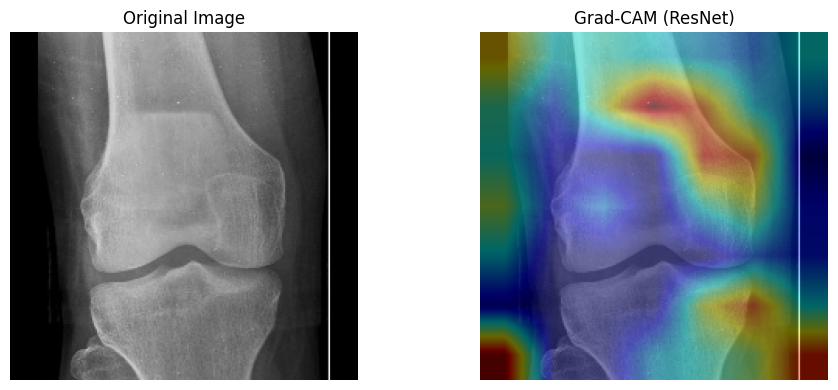

In [43]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch.nn as nn
from collections import OrderedDict

# Set number of classes as used in training
NUM_CLASSES = 3  # ← Replace with your actual number if different

# Define the same custom model structure


# Instantiate the model with correct head
# model = get_resnet_model(3)
model = get_resnet50(3)

# Load the weights
state_dict = torch.load(weights_path, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

# Target the last convolutional layer (usually 'layer4[-1]')
target_layer = model.layer4[-1]

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])



# Hook to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, pred_class].backward()

# Get hooked data
grads = gradients[0]  # [B, C, H, W]
acts = activations[0]  # [B, C, H, W]

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

# Normalize and resize CAM
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert image for display
img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Display result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM (ResNet)')
plt.imshow(superimposed[:, :, ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.tight_layout()
plt.show()

# Cleanup
handle_f.remove()
handle_b.remove()


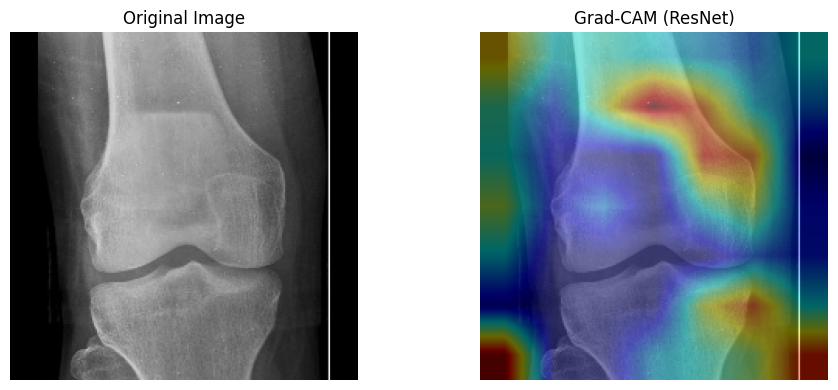

In [44]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load pretrained ResNet
# model = models.resnet50(pretrained=True)
model.eval()

# Target the last convolutional layer (usually 'layer4[-1]')
target_layer = model.layer4[-1]

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Hook to capture gradients and activations
activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# Register hooks
handle_f = target_layer.register_forward_hook(forward_hook)
handle_b = target_layer.register_backward_hook(backward_hook)

# Forward pass
output = model(input_tensor)
pred_class = output.argmax().item()

# Backward pass
model.zero_grad()
output[0, pred_class].backward()

# Get hooked data
grads = gradients[0]  # [B, C, H, W]
acts = activations[0]  # [B, C, H, W]

# Compute Grad-CAM
weights = grads.mean(dim=(2, 3), keepdim=True)
cam = (weights * acts).sum(dim=1, keepdim=True)
cam = F.relu(cam)
cam = cam.squeeze().detach().numpy()

# Normalize and resize CAM
cam = cv2.resize(cam, (224, 224))
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert image for display
img_np = np.array(image.resize((224, 224)))
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
superimposed = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# Display result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM (ResNet)')
plt.imshow(superimposed[:, :, ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.tight_layout()
plt.show()

# Cleanup
handle_f.remove()
handle_b.remove()


In [48]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import OrderedDict

# ------------------ Model Setup ------------------

NUM_CLASSES = 3

def get_custom_resnet(num_classes):
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(OrderedDict([
        ("fc1", nn.Linear(num_ftrs, 512)),
        ("relu1", nn.ReLU()),
        ("dropout", nn.Dropout(0.5)),
        ("fc2", nn.Linear(512, num_classes)),
        ("output", nn.LogSoftmax(dim=1)),
    ]))
    return model

def load_model(weights_path):
    model = get_custom_resnet(NUM_CLASSES)
    state_dict = torch.load(weights_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()
    return model

# ------------------ Grad-CAM Core ------------------

def register_hooks(model, target_layer, activations, gradients):
    def forward_hook(module, input, output):
        activations.append(output)
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)
    return handle_f, handle_b

def compute_gradcam(activations, gradients):
    grads = gradients[0]
    acts = activations[0]
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam).squeeze().detach().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

def overlay_heatmap(image, cam):
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    image_np = np.array(image.resize((224, 224)))
    superimposed = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)
    return image_np, superimposed

# ------------------ Preprocessing & Visualization ------------------

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def process_image(image_path, model, target_layer):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)

    activations, gradients = [], []
    handle_f, handle_b = register_hooks(model, target_layer, activations, gradients)

    # Forward and backward pass
    output = model(input_tensor)
    pred_class = output.argmax().item()
    model.zero_grad()
    output[0, pred_class].backward()

    # Compute Grad-CAM and overlay
    cam = compute_gradcam(activations, gradients)
    img_np, heatmap_overlay = overlay_heatmap(image, cam)

    # Remove hooks
    handle_f.remove()
    handle_b.remove()

    return img_np, heatmap_overlay, pred_class

def visualize(img_np, heatmap_overlay, filename):
    plt.figure(figsize=(10, 4))
    plt.suptitle(f'Prediction for: {filename}', fontsize=12)

    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(img_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Grad-CAM')
    plt.imshow(heatmap_overlay[:, :, ::-1])  # BGR to RGB
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ------------------ Main Loop ------------------

def run_gradcam_on_folder(image_folder, model):
    target_layer = model.layer4[-1]

    image_files = [f for f in os.listdir(image_folder)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    i=0
    for img_file in image_files:
        i+=1
        img_path = os.path.join(image_folder, img_file)
        img_np, heatmap_overlay, pred_class = process_image(img_path, model, target_layer)
        visualize(img_np, heatmap_overlay, img_file)
        if i>50:
            break

# ------------------ Execute ------------------




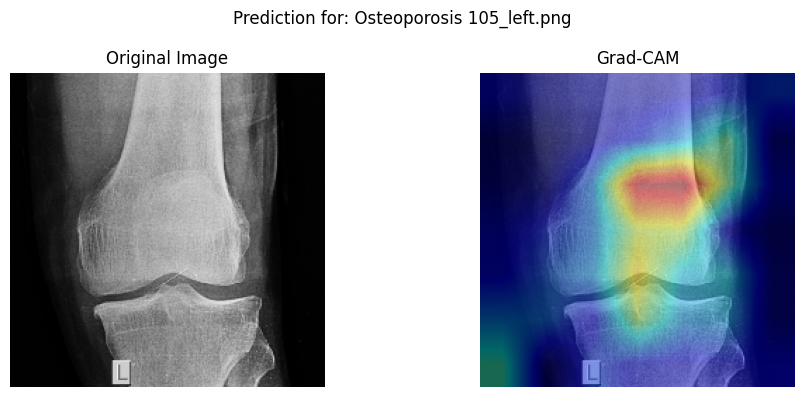

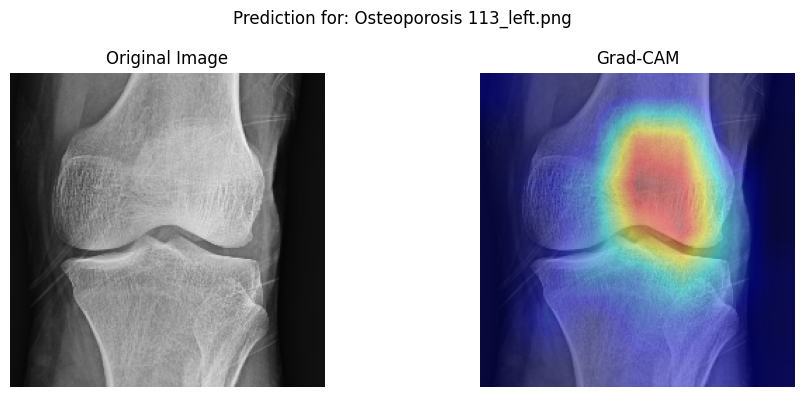

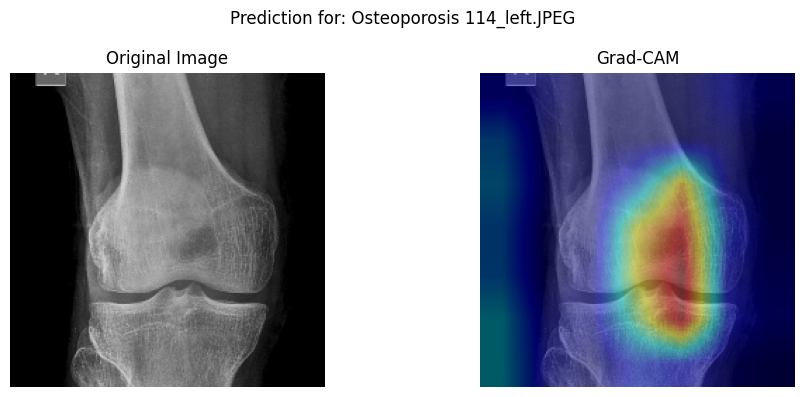

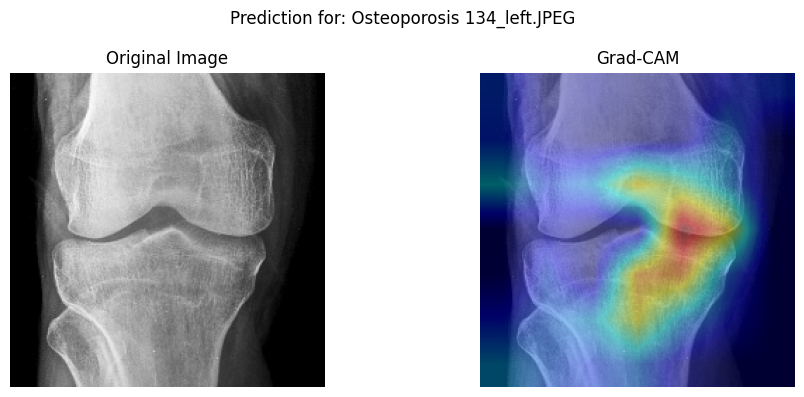

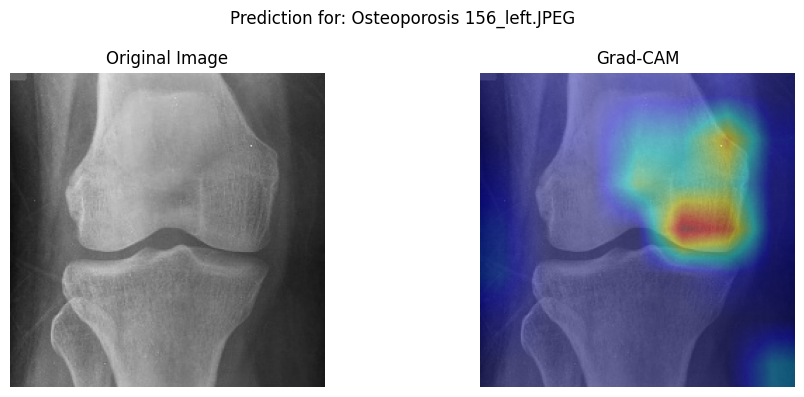

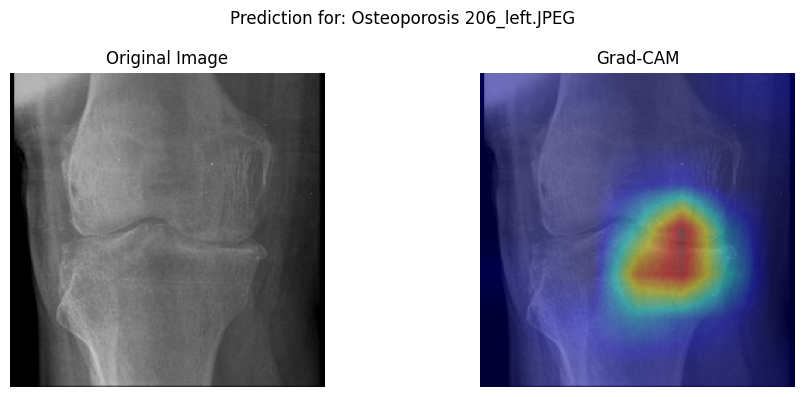

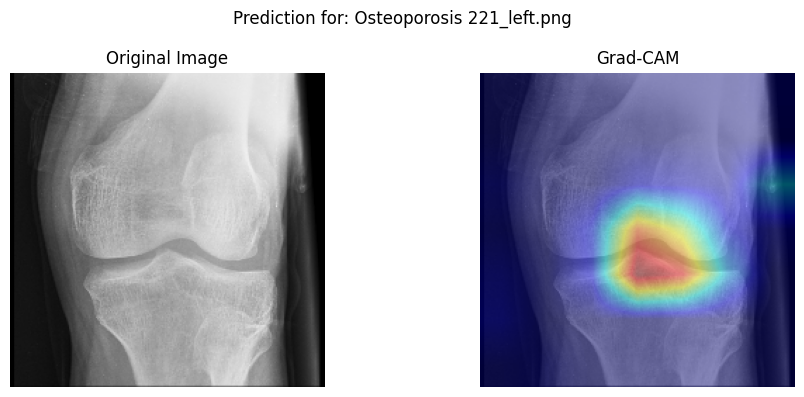

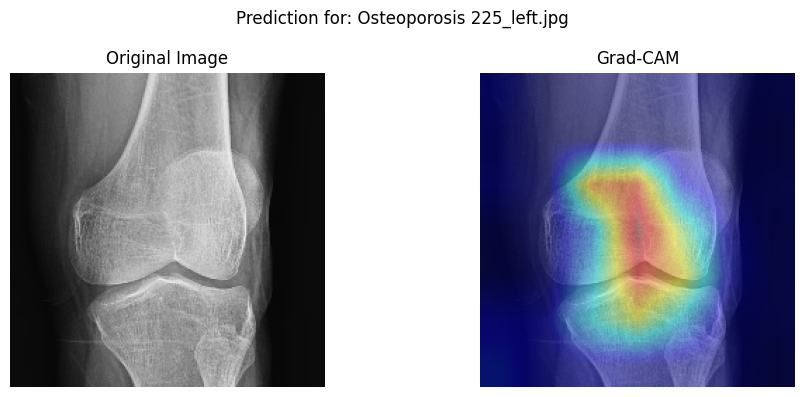

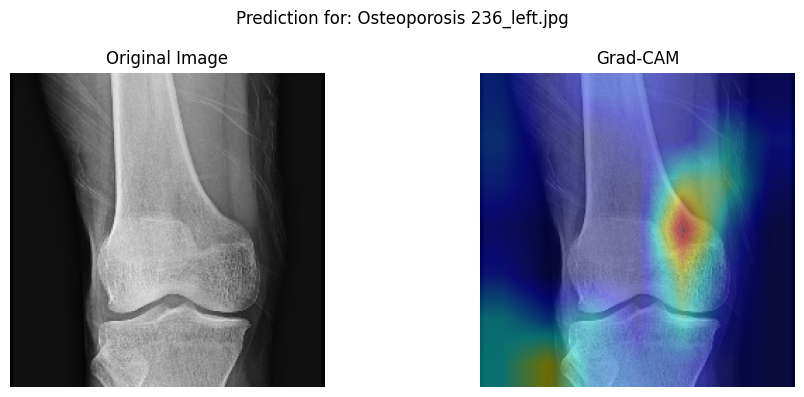

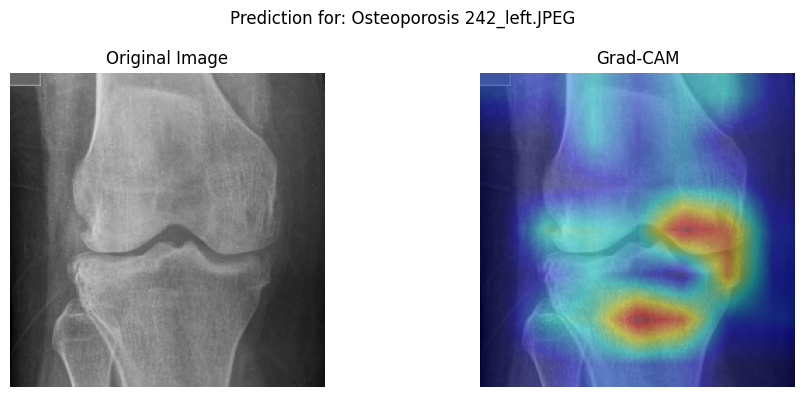

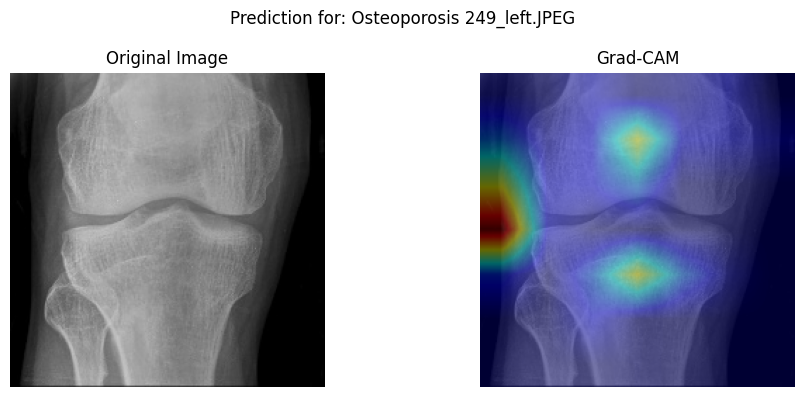

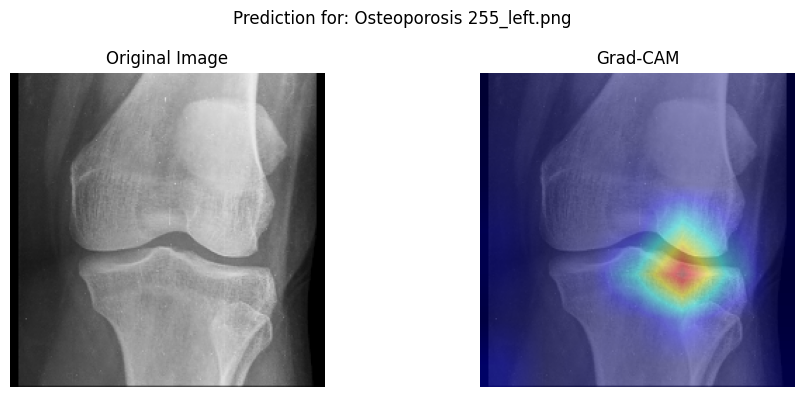

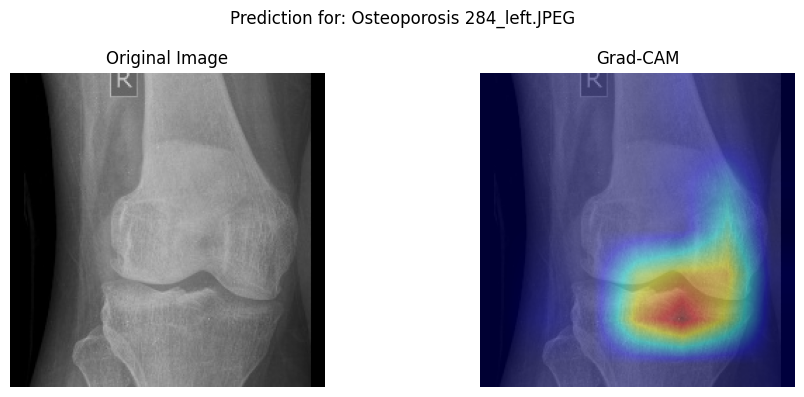

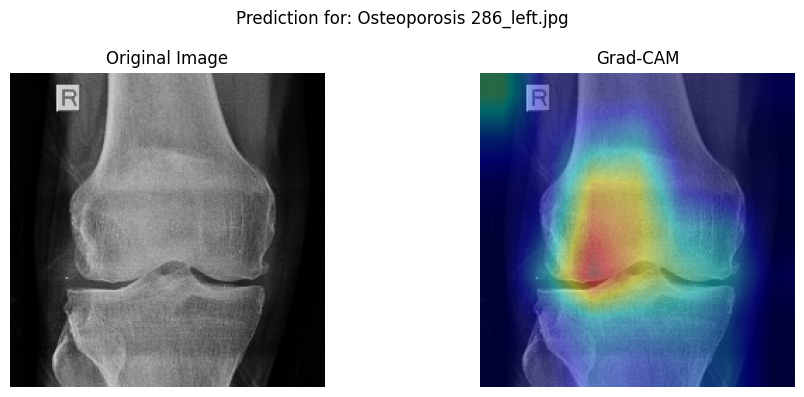

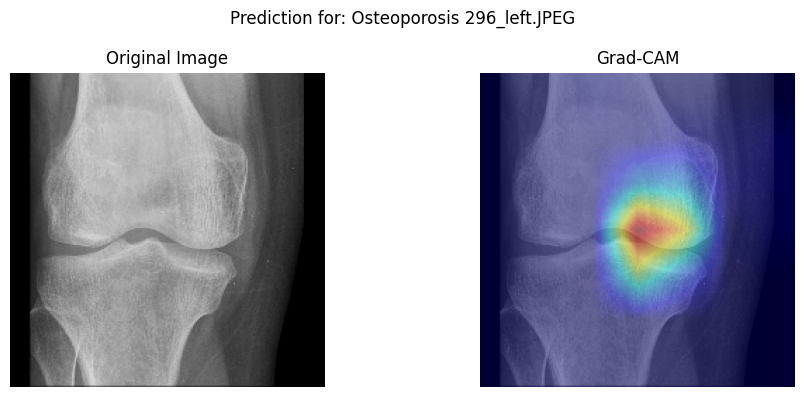

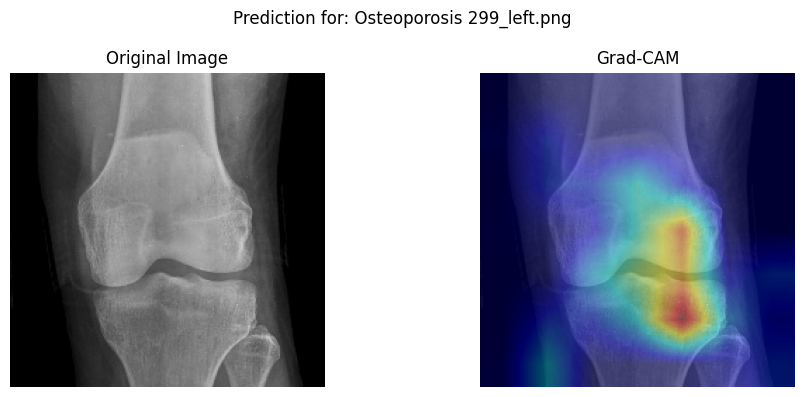

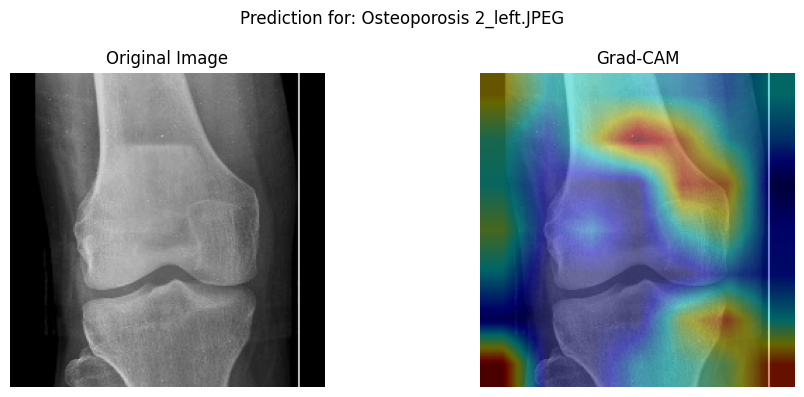

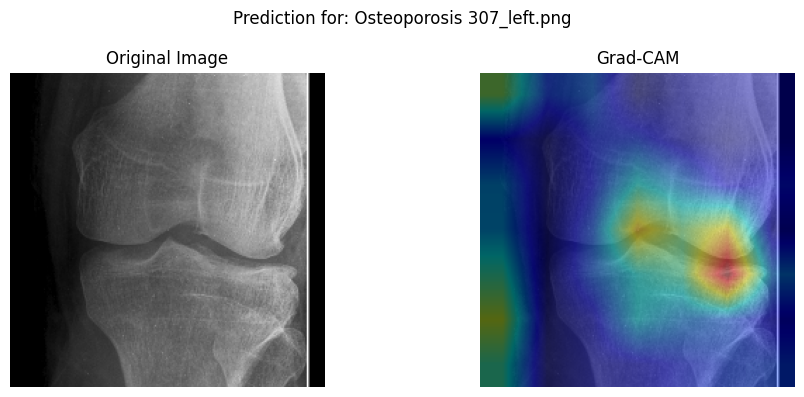

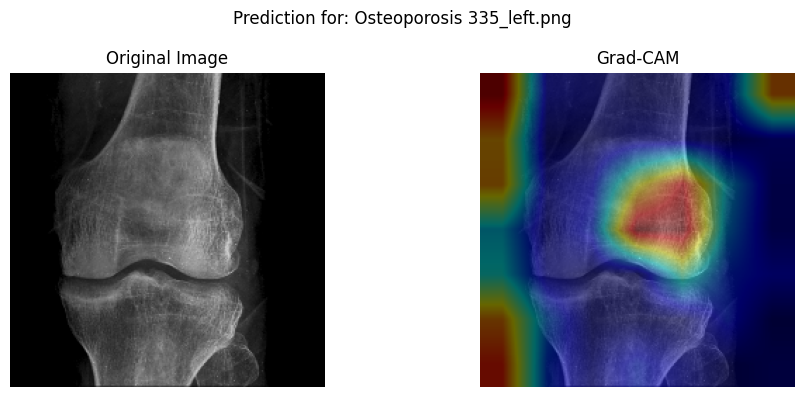

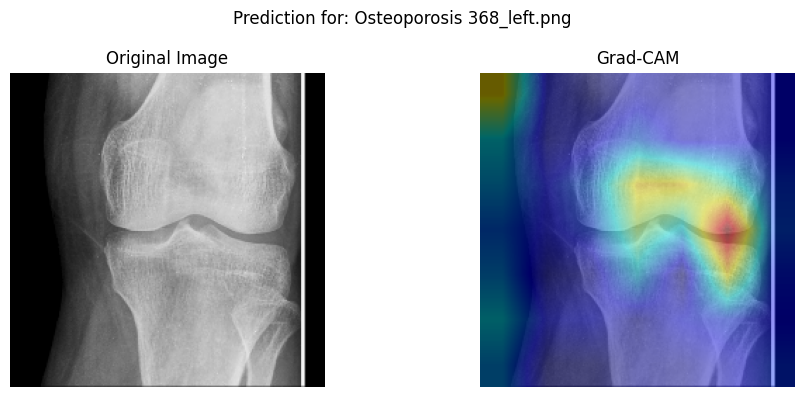

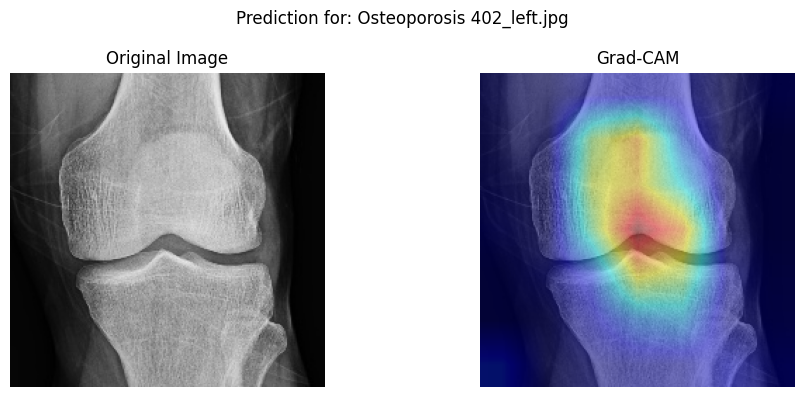

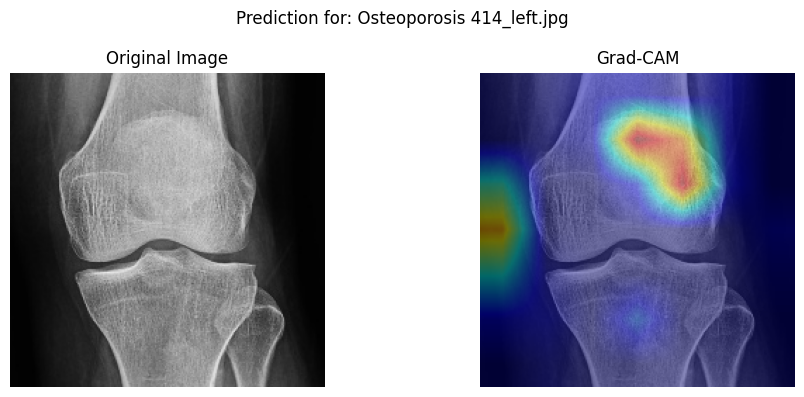

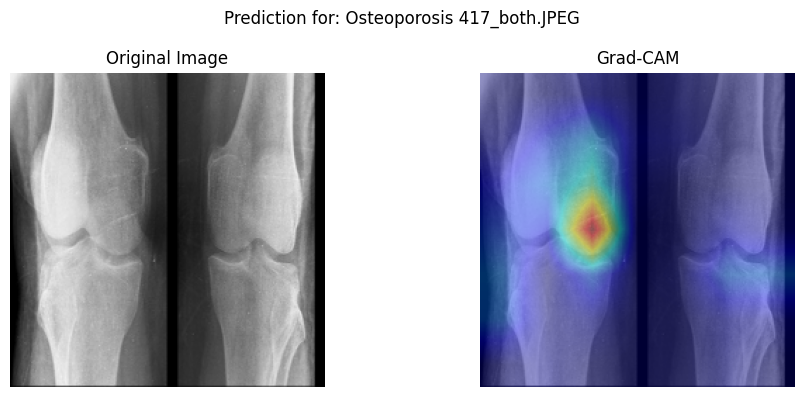

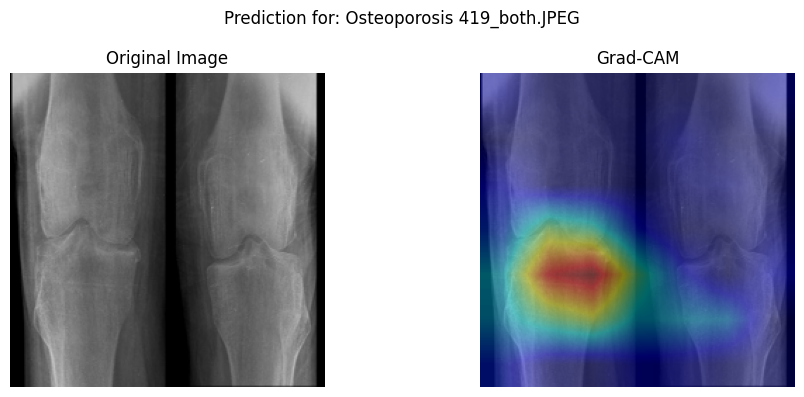

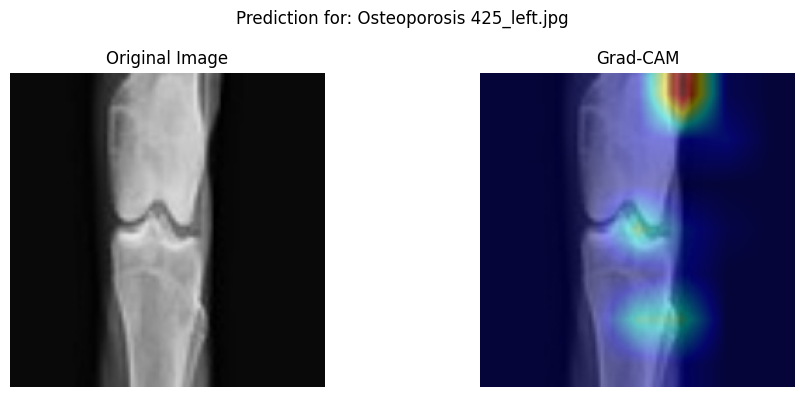

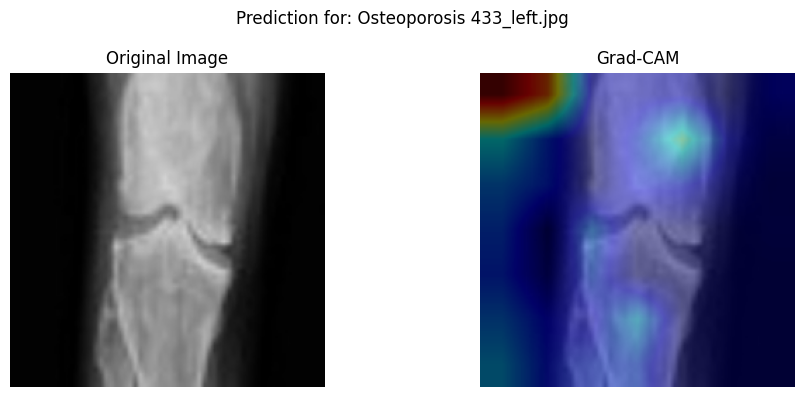

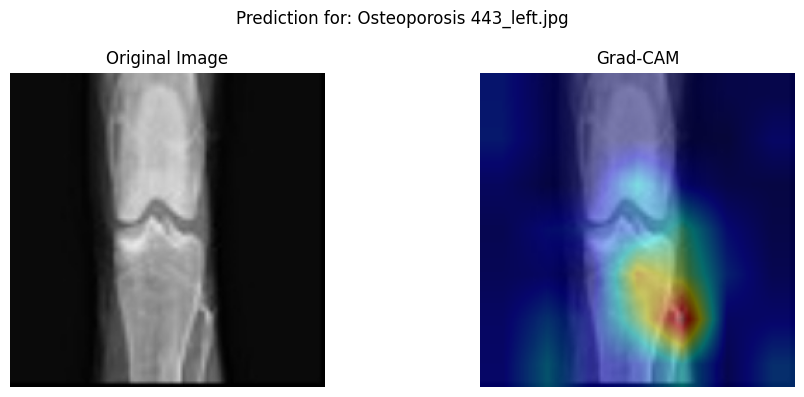

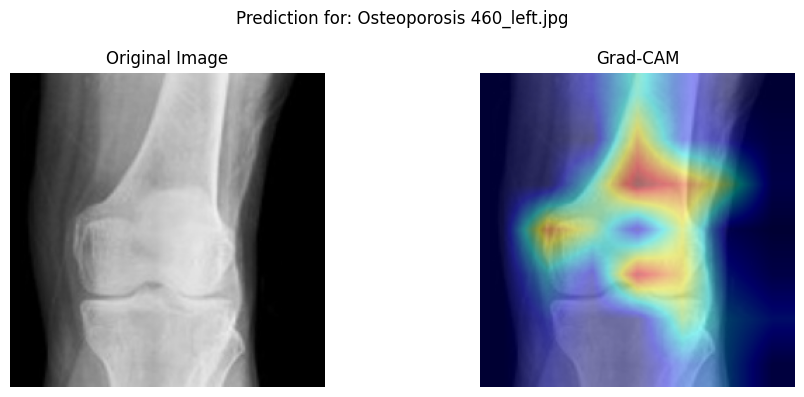

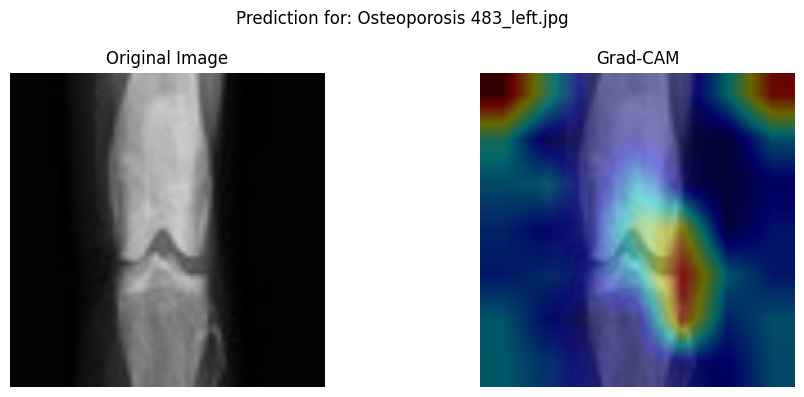

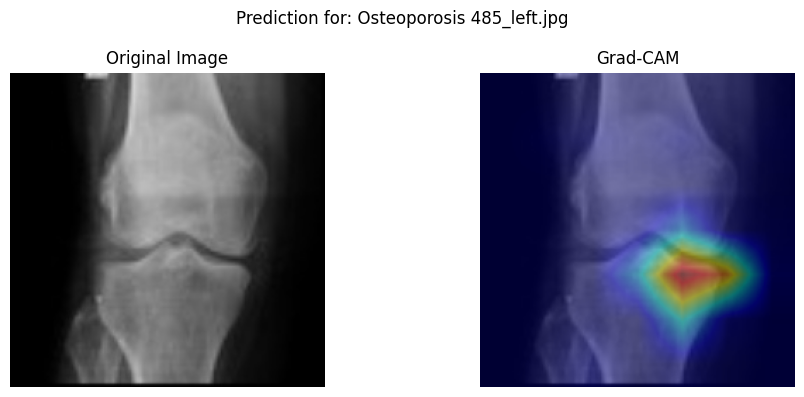

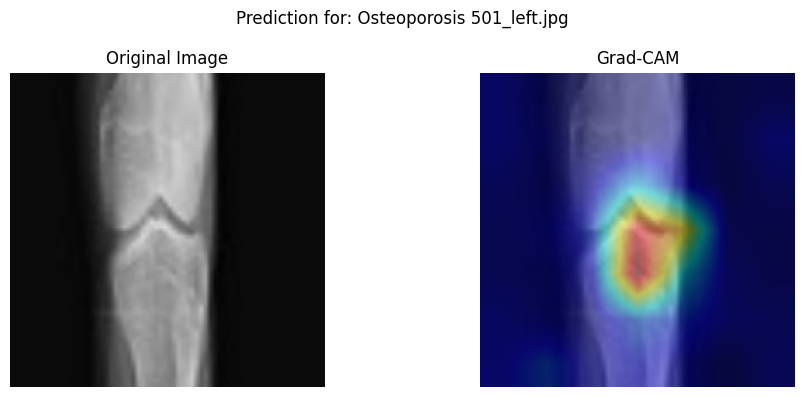

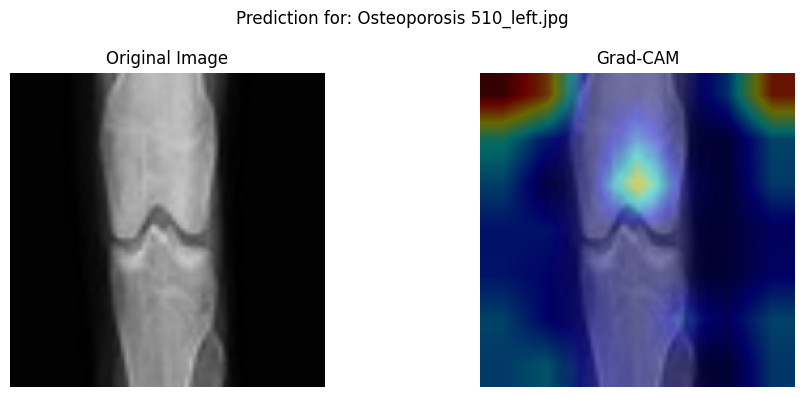

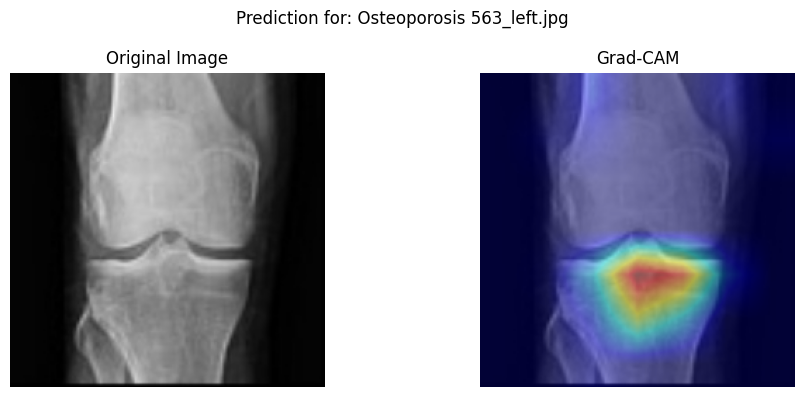

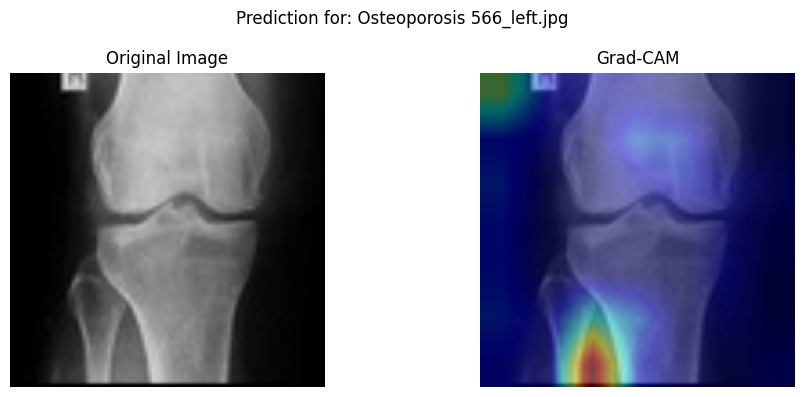

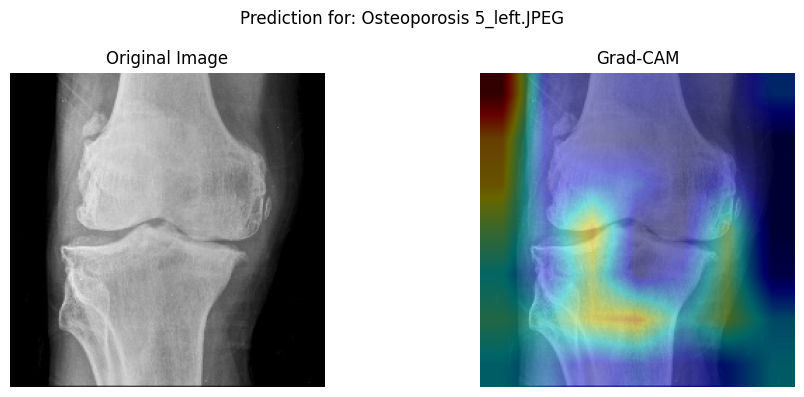

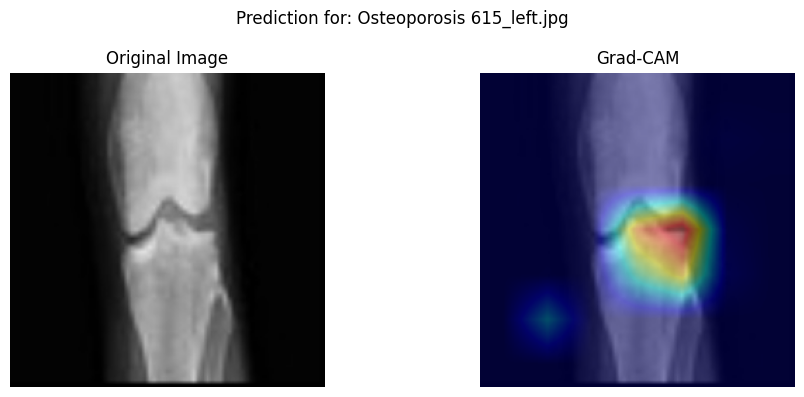

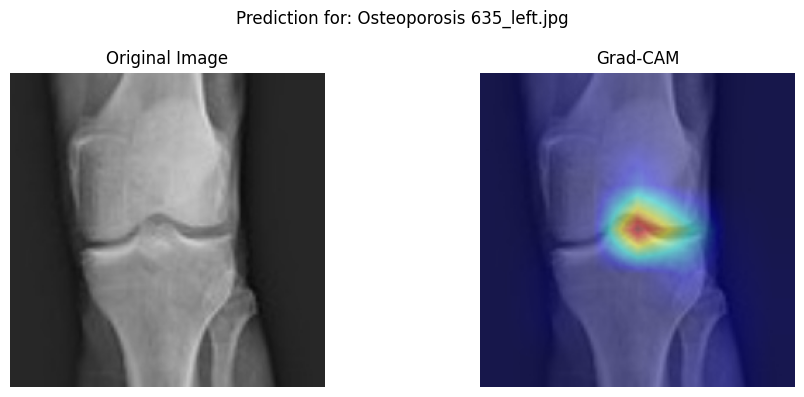

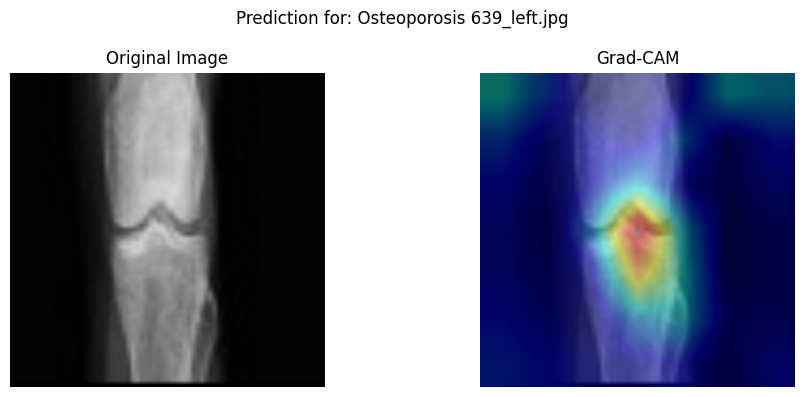

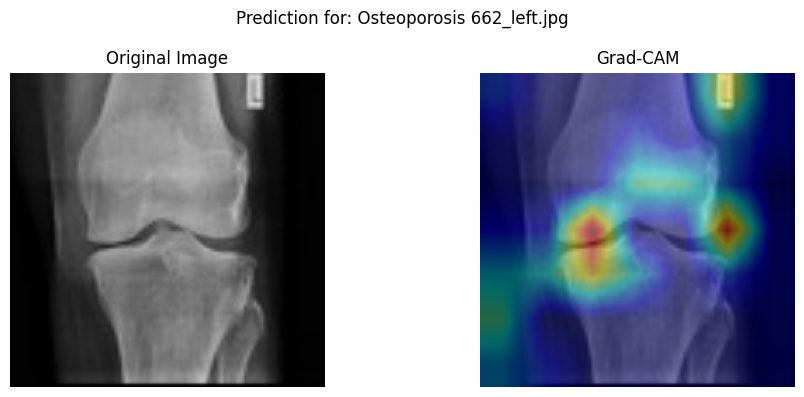

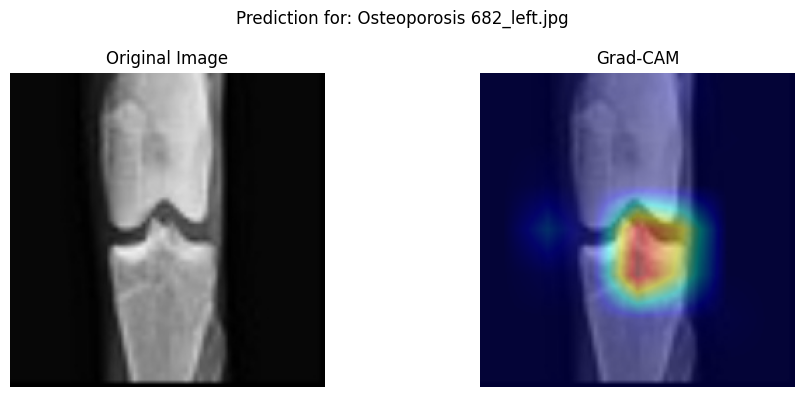

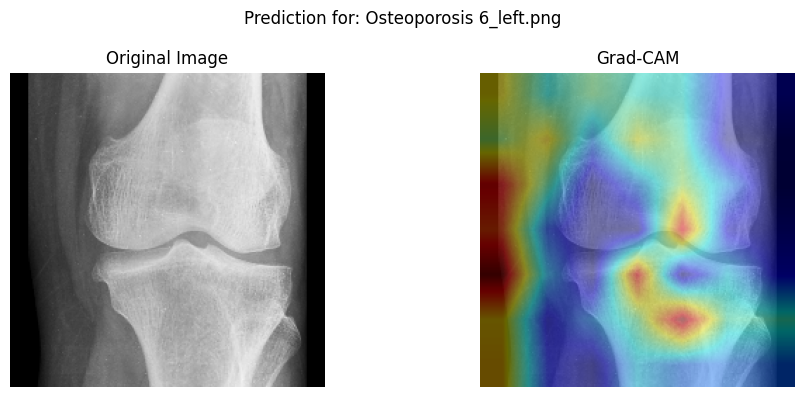

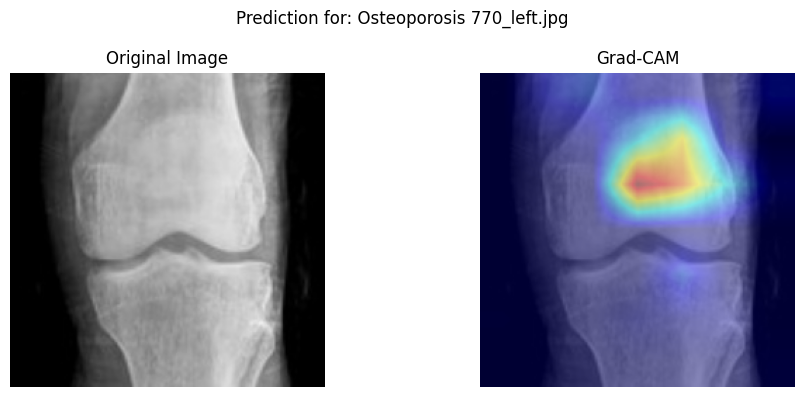

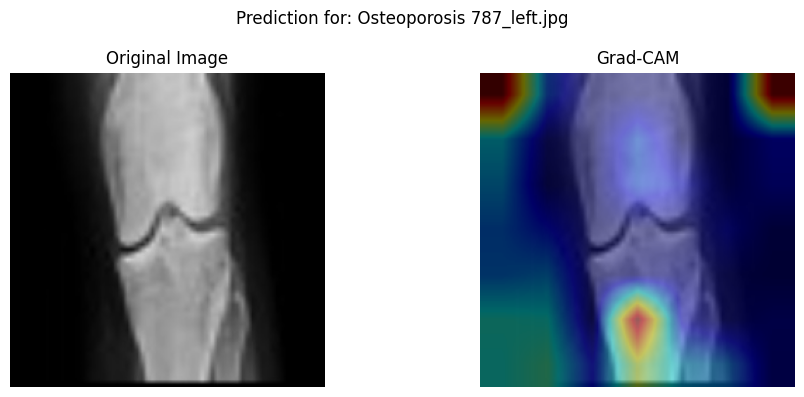

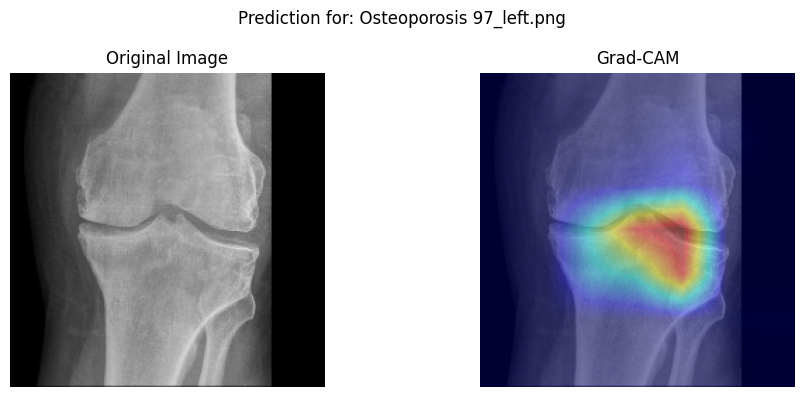

In [49]:
image_folder = r"data\grand_finalle_data\cropped_by_yolo\test_data\Osteoporosis"
# weights_path = r'C:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\saved_models\ResNet50_best_2.pth'
run_gradcam_on_folder(image_folder, model)

In [ ]:
# 